In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings('ignore')


### Clustering with KMeans

In [2]:
# ´Patient 1´

# /home/liubov/Bureau/new/8-5-2024_#18_INDIVIDUAL_[12]/processed by chunks/PosesDir/new_jsons_merged_id_1.json
# %run /home/liubov/Bureau/feature_extraction/analyze_joint_variance.py
joint_positions = pd.read_csv("joint_positions.csv")

# Create a mapping dictionary
patient_rename_map = {
    'Patient1': 'Patient_1',
    'Patient2': 'Therapist_1',
    'Patient3': 'Therapist_2'
}

# Apply the renaming to the 'Patient' column
joint_positions['Patient'] = joint_positions['Patient'].replace(patient_rename_map)
joint_positions.to_csv("joint_positions.csv")

joint_positions_patient1 = joint_positions[joint_positions.Patient=='Patient_1']
# # Pivot to get features: one row per frame, one column per joint/coordinate
df_pivot = joint_positions_patient1.pivot_table(
    index='Frame',
    columns='Joint',
    values=['X', 'Y']
)

# # Flatten MultiIndex columns: ('X', 'LeftHip') → 'X_LeftHip'
df_pivot.columns = [f"{coord}_{joint}" for coord, joint in df_pivot.columns]
df_pivot = df_pivot.dropna()  # Remove frames with missing joints

df_pivot.head()

,X_Background,X_LAnkle,X_LBigToe,X_LEar,X_LElbow,X_LEye,X_LHeel,X_LHip,X_LKnee,X_LShoulder,...,Y_RBigToe,Y_REar,Y_RElbow,Y_REye,Y_RHeel,Y_RHip,Y_RKnee,Y_RShoulder,Y_RSmallToe,Y_RWrist
Frame,,,,,,,,,,,,,,,,,,,,,
62,446.51364,395.94577,460.27704,416.21960,423.62347,416.35920,456.22820,390.44400,447.98980,425.88098,...,197.89607,199.16190,94.596460,187.47496,157.84230,106.939644,107.61823,95.820720,151.19637,98.068886
63,447.24280,396.01770,460.73782,416.21204,423.48914,416.34390,456.88490,390.66760,448.15080,425.76130,...,197.88039,199.36084,95.014984,187.70726,158.56786,107.199326,107.85085,96.132850,152.29877,98.293980
64,447.24344,396.02680,461.97952,416.62744,423.47894,416.44350,458.33725,390.68436,448.58330,425.75363,...,197.86183,199.76929,95.143290,187.99518,158.30382,107.470140,108.26997,96.309580,151.80446,98.695076
66,450.00043,396.46722,463.06332,416.84540,423.43295,416.88837,459.54040,390.74228,449.06265,425.73196,...,198.60430,202.32072,95.055466,190.42198,158.24200,107.562096,108.57880,96.251144,150.93953,98.844574
67,450.64420,396.80057,463.44098,417.07205,423.42294,417.20706,459.99730,390.75336,449.42767,425.72100,...,199.26654,202.88990,95.176680,191.10252,158.60226,107.753180,108.82244,96.399190,151.20506,99.080060


In [3]:
# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_pivot)

# Run KMeans
kmeans = KMeans(n_clusters=2, random_state=42)
df_pivot['Cluster'] = kmeans.fit_predict(X_scaled)

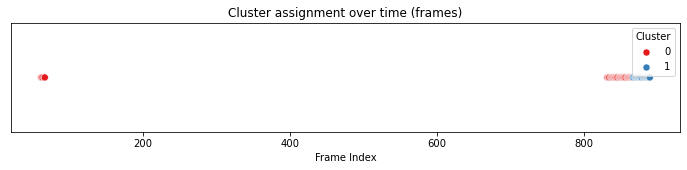

In [4]:
# Cluster assignments over time
plt.figure(figsize=(12, 2))
sns.scatterplot(x=df_pivot.index, y=[1]*len(df_pivot), hue=df_pivot['Cluster'], palette='Set1', s=50)
plt.title("Cluster assignment over time (frames)")
plt.yticks([])
plt.xlabel("Frame Index")
plt.legend(title="Cluster")
plt.show()

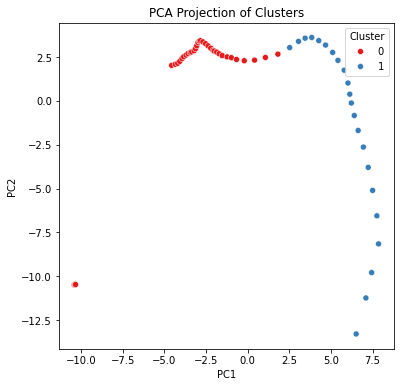

In [5]:
# PCA projection

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(6, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=df_pivot['Cluster'], palette='Set1')
plt.title("PCA Projection of Clusters")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()


In [6]:
df_pivot.groupby('Cluster').mean().filter(like='Y_')

,Y_Background,Y_LAnkle,Y_LBigToe,Y_LEar,Y_LElbow,Y_LEye,Y_LHeel,Y_LHip,Y_LKnee,Y_LShoulder,...,Y_RBigToe,Y_REar,Y_RElbow,Y_REye,Y_RHeel,Y_RHip,Y_RKnee,Y_RShoulder,Y_RSmallToe,Y_RWrist
Cluster,,,,,,,,,,,,,,,,,,,,,
0,246.828086,145.480849,165.050736,175.498025,101.781110,164.350356,163.720013,112.133613,170.479326,102.92849,...,167.283663,170.469104,105.799066,168.167972,183.148648,115.693120,113.652274,105.777947,193.152794,104.001415
1,449.757729,302.385492,359.264985,340.836108,244.704958,325.779195,356.200929,258.278275,378.880847,247.49446,...,331.145796,374.150591,259.408644,366.737361,360.541066,273.392434,266.659119,257.981028,389.938200,250.125221


- Cluster 0:

Y values are smaller → body joints are higher in the image

Hips ~112, knees ~170, shoulders ~102

This suggests: person is **standing** (joints are upright, not compressed)

- Cluster 1:

Y values are larger → body joints are lower in the image

Hips ~258, knees ~378, shoulders ~247

This suggests: person is **sitting** (hips and knees are closer to the ground)

Processing patients/therapists: Patient_1


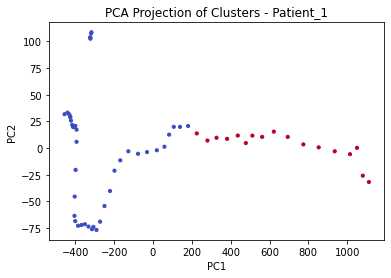

Processing patients/therapists: Therapist_1


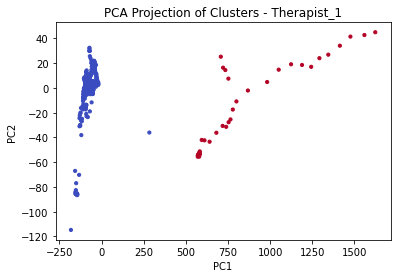

Processing patients/therapists: Therapist_2


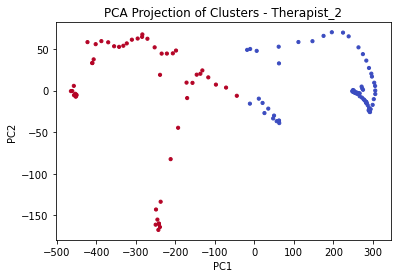

     Patient  Frame      Pose
0  Patient_1     62  Standing
1  Patient_1     63  Standing
2  Patient_1     64  Standing
3  Patient_1     66  Standing
4  Patient_1     67  Standing
Pose
Standing    525
Sitting     123
Name: count, dtype: int64


In [7]:
# Store results for all patients/therapists

all_clustered_data = []

# Loop over each patients/therapists
for patient_id in joint_positions['Patient'].unique():
    print(f"Processing patients/therapists: {patient_id}")
    
    df_patient = joint_positions[joint_positions['Patient'] == patient_id]

    # Pivot to get one row per frame with all joint Y coordinates
    df_pivot = df_patient.pivot_table(index='Frame', columns='Joint', values='Y')

    df_pivot.columns = [f"Y_{col}" for col in df_pivot.columns]
    df_pivot = df_pivot.dropna()

    if df_pivot.empty:
        print(f"  - Skipping {patient_id}, not enough data.")
        continue

    # Run PCA for visualization (optional)
    pca = PCA(n_components=2)
    pca_proj = pca.fit_transform(df_pivot)

    # Cluster with KMeans
    kmeans = KMeans(n_clusters=2, random_state=42)
    df_pivot['Cluster'] = kmeans.fit_predict(df_pivot)

    # Infer which cluster is "Sitting" vs "Standing" based on Y_Hip or mean Y
    cluster_means = df_pivot.groupby('Cluster').mean()
    standing_cluster = cluster_means.mean(axis=1).idxmin()  # Lower Y = higher = standing
    sitting_cluster = cluster_means.mean(axis=1).idxmax()

    cluster_to_pose = {
        standing_cluster: 'Standing',
        sitting_cluster: 'Sitting'
    }

    df_pivot['Pose'] = df_pivot['Cluster'].map(cluster_to_pose)
    df_pivot['Patient'] = patient_id
    df_pivot['Frame'] = df_pivot.index

    all_clustered_data.append(df_pivot.reset_index(drop=True))

    # Optional: Plot PCA
    plt.figure(figsize=(6, 4))
    plt.scatter(pca_proj[:, 0], pca_proj[:, 1], c=df_pivot['Cluster'], cmap='coolwarm', s=10)
    plt.title(f'PCA Projection of Clusters - {patient_id}')
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.show()

# Concatenate all results into one DataFrame
pose_clusters_all = pd.concat(all_clustered_data, ignore_index=True)

# Preview
print(pose_clusters_all[['Patient', 'Frame', 'Pose']].head())
print(pose_clusters_all.Pose.value_counts())


In [8]:
pose_counts = pose_clusters_all.groupby(['Patient', 'Pose']).size().unstack(fill_value=0)

# Optional: Normalize to get % time spent
pose_ratios = pose_counts.div(pose_counts.sum(axis=1), axis=0) * 100

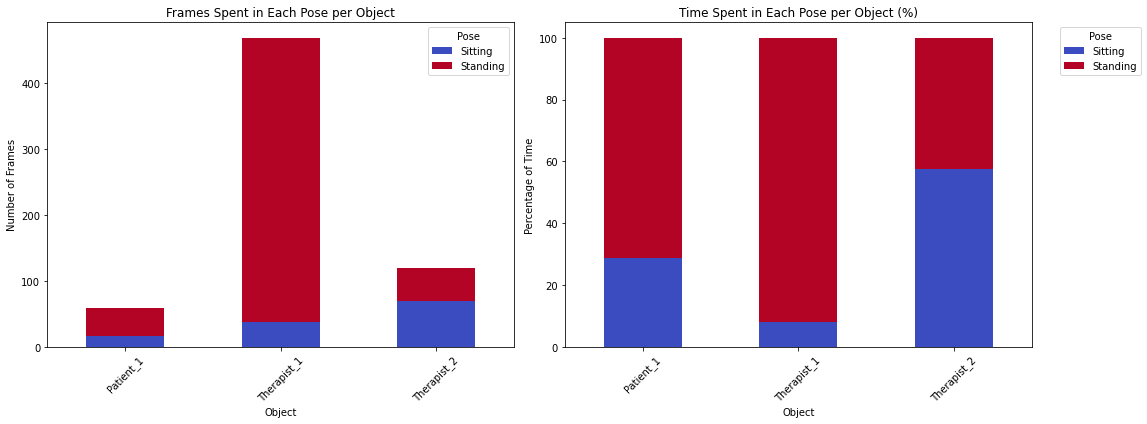

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=False)

# --- Plot 1: Raw Counts ---
pose_counts.plot(kind='bar', 
                 stacked=True, 
                 ax=axes[0], 
                 colormap='coolwarm')

axes[0].set_title('Frames Spent in Each Pose per Object')
axes[0].set_ylabel('Number of Frames')
axes[0].set_xlabel('Object')
axes[0].tick_params(axis='x', rotation=45)
axes[0].legend(title='Pose')

# --- Plot 2: Percentages ---
pose_ratios.plot(kind='bar', 
                 stacked=True, 
                 ax=axes[1], 
                 colormap='coolwarm')

axes[1].set_title('Time Spent in Each Pose per Object (%)')
axes[1].set_ylabel('Percentage of Time')
axes[1].set_xlabel('Object')
axes[1].tick_params(axis='x', rotation=45)
axes[1].legend(title='Pose', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()


In [10]:
pose_clusters_all.columns

Index(['Y_Background', 'Y_LAnkle', 'Y_LBigToe', 'Y_LEar', 'Y_LElbow', 'Y_LEye',
       'Y_LHeel', 'Y_LHip', 'Y_LKnee', 'Y_LShoulder', 'Y_LSmallToe',
       'Y_LWrist', 'Y_MidHip', 'Y_Neck', 'Y_Nose', 'Y_RAnkle', 'Y_RBigToe',
       'Y_REar', 'Y_RElbow', 'Y_REye', 'Y_RHeel', 'Y_RHip', 'Y_RKnee',
       'Y_RShoulder', 'Y_RSmallToe', 'Y_RWrist', 'Cluster', 'Pose', 'Patient',
       'Frame'],
      dtype='object')

In [11]:
joint_positions.head()

,Unnamed: 0,Patient,Joint,Frame,X,Y
0,0,Patient_1,Nose,5,436.66135,76.533104
1,1,Patient_1,Nose,6,436.66068,76.558914
2,2,Patient_1,Nose,7,436.50210,78.160120
3,3,Patient_1,Nose,8,436.44742,78.432010
4,4,Patient_1,Nose,9,436.44205,78.703476


In [12]:
# Merge joint_positions with cluster+pose info from pose_clusters_all
joint_positions_with_pose = joint_positions.merge(
    pose_clusters_all[['Patient', 'Frame', 'Cluster', 'Pose']],
    on=['Patient', 'Frame'],
    how='left'  # keep all rows from joint_positions
)
# print(joint_positions_with_pose.Pose.isna().sum())
# print(len(joint_positions_with_pose))

Processing patient: Patient_1


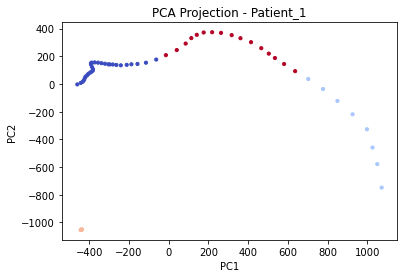

Processing patient: Therapist_1


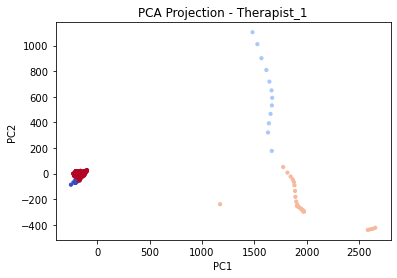

Processing patient: Therapist_2


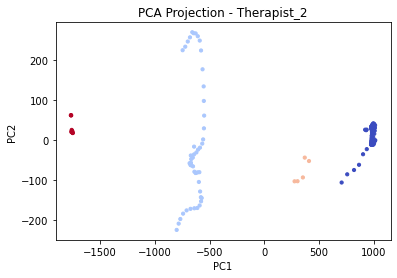

In [13]:
# Code for Multi-Class Pose Clustering

# Choose number of clusters (e.g., 3: Standing, Sitting, Lying)
N_CLUSTERS = 4

# Store all results
all_clustered_data = []

for patient_id in joint_positions['Patient'].unique():
    print(f"Processing patient: {patient_id}")
    
    df_patient = joint_positions[joint_positions['Patient'] == patient_id]

    # Pivot X and Y
    df_pivot_x = df_patient.pivot_table(index='Frame', columns='Joint', values='X')
    df_pivot_y = df_patient.pivot_table(index='Frame', columns='Joint', values='Y')

    # Combine X and Y
    df_features = pd.concat([
        df_pivot_x.add_prefix('X_'),
        df_pivot_y.add_prefix('Y_')
    ], axis=1).dropna()

    if df_features.empty:
        print(f"  - Skipping {patient_id}, not enough data.")
        continue

    # PCA projection for visualization
    pca = PCA(n_components=2)
    pca_proj = pca.fit_transform(df_features)

    # KMeans clustering
    kmeans = KMeans(n_clusters=N_CLUSTERS, random_state=42)
    df_features['Cluster'] = kmeans.fit_predict(df_features)

    # Use only Y to determine pose height (for interpretation)
    y_only = df_pivot_y.loc[df_features.index]
    y_only['Cluster'] = df_features['Cluster']
    cluster_y_means = y_only.groupby('Cluster').mean().mean(axis=1)

    # Sort clusters by Y (lower Y = higher body = standing)
    sorted_clusters = cluster_y_means.sort_values().index.tolist()

    # Map sorted clusters to poses
    sorted_clusters = cluster_y_means.sort_values().index.tolist()
    pose_names = ['Standing', 'Sitting', 'Lying', 'Unknown']
    cluster_to_pose = {cluster: pose for cluster, pose in zip(sorted_clusters, pose_names)}


    # Assign pose labels
    df_features['Pose'] = df_features['Cluster'].map(cluster_to_pose)
    df_features['Patient'] = patient_id
    df_features['Frame'] = df_features.index

    all_clustered_data.append(df_features.reset_index(drop=True))

    # Optional PCA plot
    plt.figure(figsize=(6, 4))
    plt.scatter(pca_proj[:, 0], pca_proj[:, 1], c=df_features['Cluster'], cmap='coolwarm', s=10)
    plt.title(f'PCA Projection - {patient_id}')
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.show()


In [14]:
# Combine all
pose_clusters_all = pd.concat(all_clustered_data, ignore_index=True)

# Keep columns to merge
pose_assignments = pose_clusters_all[['Patient', 'Frame', 'Pose', 'Cluster']]

# Merge
joint_positions_with_pose = joint_positions.merge(
    pose_assignments,
    on=['Patient', 'Frame'],
    how='left'
)


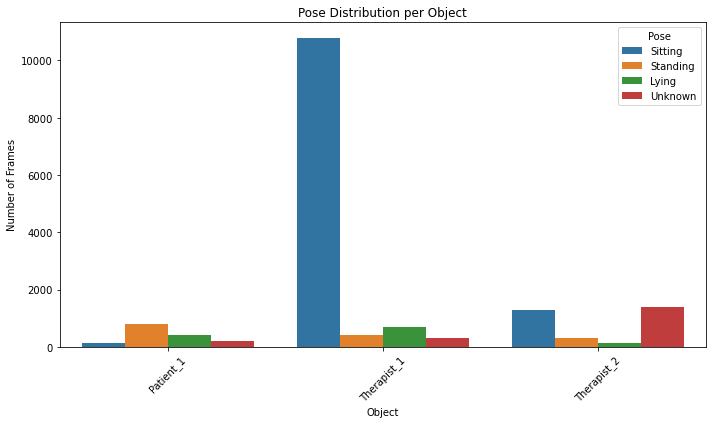

In [15]:
plt.figure(figsize=(10, 6))
sns.countplot(data=joint_positions_with_pose, x='Patient', hue='Pose')
plt.title("Pose Distribution per Object")
plt.ylabel("Number of Frames")
plt.xlabel("Object")
plt.xticks(rotation=45)
plt.legend(title='Pose')
plt.tight_layout()
plt.show()


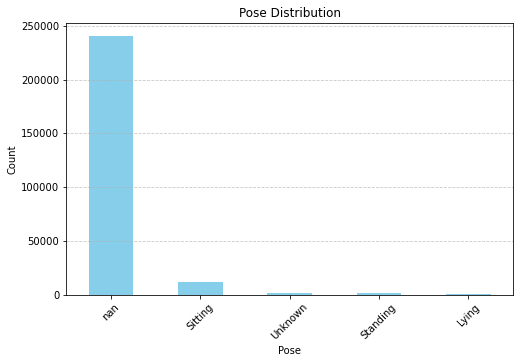

In [16]:
pose_counts = joint_positions_with_pose['Pose'].value_counts(dropna=False)

plt.figure(figsize=(8, 5))
pose_counts.plot(kind='bar', color='skyblue')
plt.title('Pose Distribution')
plt.xlabel('Pose')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Cluster to Pose Mapping:
Cluster 0 → Pose: Standing
Cluster 1 → Pose: Sitting
Cluster 2 → Pose: Lying
Cluster 3 → Pose: Leaning
Mean Y coordinate per cluster:
Cluster
0    213.592569
1    253.291987
2    260.341761
3    155.013131
Name: Mean_Y, dtype: float64


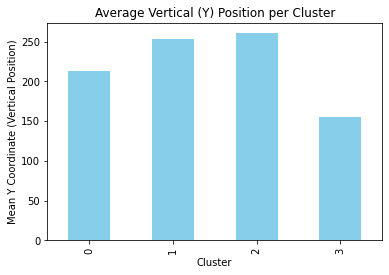

In [17]:
cluster_to_pose = {
    0: 'Standing',
    1: 'Sitting',
    2: 'Lying',
    3: 'Leaning'
}
print("Cluster to Pose Mapping:")
for cluster, pose in cluster_to_pose.items():
    print(f"Cluster {cluster} → Pose: {pose}")

# Calculate mean Y values per cluster for all joints that start with 'Y_'
mean_y_per_cluster = pose_clusters_all.groupby('Cluster').mean(numeric_only=True).filter(like='Y_')

# Calculate overall mean vertical position per cluster (averaging all Y_ joints)
mean_y_per_cluster['Mean_Y'] = mean_y_per_cluster.mean(axis=1)

print("Mean Y coordinate per cluster:")
print(mean_y_per_cluster['Mean_Y'])

# Plot mean Y per cluster
mean_y_per_cluster['Mean_Y'].plot(kind='bar', color='skyblue')
plt.title('Average Vertical (Y) Position per Cluster')
plt.xlabel('Cluster')
plt.ylabel('Mean Y Coordinate (Vertical Position)')
plt.show()


In [18]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

# Determine optimal number of clusters
silhouette_scores = []
for k in range(2, 8):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_scaled)
    silhouette_scores.append(silhouette_score(X_scaled, labels))

In [19]:
silhouette_scores

[0.49924628065940685,
 0.6333220326142686,
 0.6650452551039361,
 0.648935775851755,
 0.5165004127181043,
 0.5117536425073245]

**Significant Issues**
1. Arbitrary Cluster Interpretation
The assumption that lower Y coordinates = standing may not hold universally. This depends on:

Camera angle and positioning
Coordinate system origin
Image resolution and cropping

2. Inconsistent Cluster-to-Pose Mapping
The code shows different mapping strategies:

First uses data-driven approach based on Y coordinates
Later uses hardcoded mapping: {0: 'Standing', 1: 'Sitting', 2: 'Lying', 3: 'Leaning'}

3. No Validation or Evaluation

No ground truth comparison
No inter-cluster distance analysis
No silhouette analysis or other clustering quality metrics
No cross-validation

4. Limited Feature Engineering

Only uses raw X,Y coordinates
Missing potentially important features:

Joint angles
Relative distances between joints
Temporal features (velocity, acceleration)
Body proportions/ratios

**Technical Concerns**
1. Feature Selection
Inconsistent feature selection without justification.
2. Cluster Number Selection

No systematic approach to choosing optimal number of clusters
No elbow method or silhouette analysis
Jumps from 2 to 4 clusters without explanation

3. Data Leakage Risk
Uses all data for clustering without proper train/validation splits, though this is less critical for unsupervised learning.


**Recommendations for Improvement**
1. Add Validation Metrics
2. Improve Feature Engineering

Calculate joint angles using trigonometry
Add relative distances between key joints
Consider temporal smoothing to reduce noise

3. Validate Pose Interpretation

Manually label a subset of frames for validation
Use domain knowledge from physiotherapy/kinesiology
Consider pose-specific anatomical constraints

4. Robustness Testing

Test on different patients/sessions
Analyze failure cases
Add confidence scores for classifications

- Domain-Specific Considerations  
The analysis appears to be for patient monitoring or therapy assessment. Consider:

Clinical relevance: Are the identified poses clinically meaningful?
Temporal patterns: Analysis of pose transitions over time
Individual differences: Patient-specific pose variations
Environmental factors: Impact of camera setup on results

- Code Quality

Generally well-structured and readable
Good use of pandas operations
Could benefit from more modular functions
Missing docstrings and comments explaining domain assumptions



In [20]:
#=================================================================
#==================== Enhaced KMeans ============================
#=================================================================

import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Dict, List, Tuple, Optional
import logging

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.model_selection import train_test_split
from scipy.spatial.distance import cdist
from scipy.signal import savgol_filter
from scipy.stats import zscore

import warnings
warnings.filterwarnings('ignore')

# Set up logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

class PoseFeatureExtractor:
    """Extract meaningful features from pose keypoints"""
    
    def __init__(self):
        self.joint_pairs = {
            'left_arm_angle': ['LeftShoulder', 'LeftElbow', 'LeftWrist'],
            'right_arm_angle': ['RightShoulder', 'RightElbow', 'RightWrist'],
            'left_leg_angle': ['LeftHip', 'LeftKnee', 'LeftAnkle'],
            'right_leg_angle': ['RightHip', 'RightKnee', 'RightAnkle'],
            'torso_angle': ['Neck', 'MidHip'],
        }
        
        self.distance_pairs = {
            'shoulder_width': ['LeftShoulder', 'RightShoulder'],
            'hip_width': ['LeftHip', 'RightHip'],
            'torso_length': ['Neck', 'MidHip'],
            'left_arm_length': ['LeftShoulder', 'LeftWrist'],
            'right_arm_length': ['RightShoulder', 'RightWrist'],
        }
    
    def calculate_angle(self, p1: np.ndarray, p2: np.ndarray, p3: np.ndarray) -> float:
        """Calculate angle at p2 formed by p1-p2-p3"""
        v1 = p1 - p2
        v2 = p3 - p2
        
        cos_angle = np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2) + 1e-8)
        cos_angle = np.clip(cos_angle, -1.0, 1.0)
        angle = np.arccos(cos_angle)
        return np.degrees(angle)
    
    def calculate_distance(self, p1: np.ndarray, p2: np.ndarray) -> float:
        """Calculate Euclidean distance between two points"""
        return np.linalg.norm(p1 - p2)
    
    def extract_basic_features(self, df_pivot: pd.DataFrame) -> pd.DataFrame:
        """Extract basic X,Y coordinate features"""
        return df_pivot.copy()
    
    def extract_angle_features(self, joint_positions: pd.DataFrame) -> pd.DataFrame:
        """Extract joint angle features"""
        angle_features = []
        
        for frame in joint_positions['Frame'].unique():
            frame_data = joint_positions[joint_positions['Frame'] == frame]
            frame_features = {'Frame': frame}
            
            for angle_name, joints in self.joint_pairs.items():
                if len(joints) == 3:
                    try:
                        points = []
                        for joint in joints:
                            joint_data = frame_data[frame_data['Joint'] == joint]
                            if not joint_data.empty:
                                points.append(np.array([joint_data['X'].iloc[0], joint_data['Y'].iloc[0]]))
                        
                        if len(points) == 3:
                            angle = self.calculate_angle(points[0], points[1], points[2])
                            frame_features[f'angle_{angle_name}'] = angle
                    except:
                        frame_features[f'angle_{angle_name}'] = np.nan
                elif len(joints) == 2:  # For torso angle
                    try:
                        points = []
                        for joint in joints:
                            joint_data = frame_data[frame_data['Joint'] == joint]
                            if not joint_data.empty:
                                points.append(np.array([joint_data['X'].iloc[0], joint_data['Y'].iloc[0]]))
                        
                        if len(points) == 2:
                            # Calculate angle with vertical
                            vertical = np.array([0, -1])  # Assuming Y increases downward
                            direction = points[1] - points[0]
                            direction = direction / (np.linalg.norm(direction) + 1e-8)
                            angle = np.arccos(np.clip(np.dot(direction, vertical), -1.0, 1.0))
                            frame_features[f'angle_{angle_name}'] = np.degrees(angle)
                    except:
                        frame_features[f'angle_{angle_name}'] = np.nan
            
            angle_features.append(frame_features)
        
        return pd.DataFrame(angle_features)
    
    def extract_distance_features(self, joint_positions: pd.DataFrame) -> pd.DataFrame:
        """Extract distance-based features"""
        distance_features = []
        
        for frame in joint_positions['Frame'].unique():
            frame_data = joint_positions[joint_positions['Frame'] == frame]
            frame_features = {'Frame': frame}
            
            for dist_name, joints in self.distance_pairs.items():
                try:
                    points = []
                    for joint in joints:
                        joint_data = frame_data[frame_data['Joint'] == joint]
                        if not joint_data.empty:
                            points.append(np.array([joint_data['X'].iloc[0], joint_data['Y'].iloc[0]]))
                    
                    if len(points) == 2:
                        distance = self.calculate_distance(points[0], points[1])
                        frame_features[f'dist_{dist_name}'] = distance
                except:
                    frame_features[f'dist_{dist_name}'] = np.nan
            
            distance_features.append(frame_features)
        
        return pd.DataFrame(distance_features)
    
    def extract_temporal_features(self, features_df: pd.DataFrame, window_size: int = 5) -> pd.DataFrame:
        """Extract temporal features like velocity and acceleration"""
        temporal_features = features_df.copy()
        
        # Smooth features first
        feature_cols = [col for col in features_df.columns if col != 'Frame']
        
        for col in feature_cols:
            if temporal_features[col].notna().sum() > window_size:
                # Apply smoothing
                valid_mask = temporal_features[col].notna()
                if valid_mask.sum() > window_size:
                    smoothed = savgol_filter(
                        temporal_features.loc[valid_mask, col].values, 
                        window_length=min(window_size, valid_mask.sum()//2*2+1), 
                        polyorder=2
                    )
                    temporal_features.loc[valid_mask, f'{col}_smoothed'] = smoothed
                
                # Calculate velocity (first derivative)
                temporal_features[f'{col}_velocity'] = temporal_features[col].diff()
                
                # Calculate acceleration (second derivative)
                temporal_features[f'{col}_acceleration'] = temporal_features[f'{col}_velocity'].diff()
        
        return temporal_features

class PoseClusteringValidator:
    """Validate clustering results and determine optimal parameters"""
    
    def __init__(self):
        self.scaler = StandardScaler()
        self.optimal_k = None
        self.silhouette_scores = {}
        self.inertia_scores = {}
    
    def find_optimal_clusters(self, X: np.ndarray, k_range: range = range(2, 8)) -> Dict:
        """Find optimal number of clusters using multiple metrics"""
        results = {
            'silhouette_scores': [], 
            'inertia_scores': [],
            'k_values': list(k_range)
        }
#The silhouette score -how well a data point fits within its assigned cluster, compared to other clusters.
#The inertia - how tightly packed the points in a cluster are; the sum of squared distances from each point to its cluster center.
        X_scaled = self.scaler.fit_transform(X)
        
        for k in k_range:
            kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
            labels = kmeans.fit_predict(X_scaled)
            
            # Silhouette score
            sil_score = silhouette_score(X_scaled, labels)
            results['silhouette_scores'].append(sil_score)
            
            # Inertia (within-cluster sum of squares)
            results['inertia_scores'].append(kmeans.inertia_)
            
            logger.info(f"k={k}: Silhouette={sil_score:.3f}, Inertia={kmeans.inertia_:.1f}")
        
        # Find optimal k using silhouette score
        best_idx = np.argmax(results['silhouette_scores'])
        self.optimal_k = results['k_values'][best_idx]
        
        logger.info(f"Optimal k based on silhouette score: {self.optimal_k}")
        
        return results
    
    def plot_validation_metrics(self, results: Dict):
        """Plot validation metrics to help choose optimal k"""
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
        
        # Silhouette scores
        ax1.plot(results['k_values'], results['silhouette_scores'], 'bo-')
        ax1.set_xlabel('Number of Clusters (k)')
        ax1.set_ylabel('Silhouette Score')
        ax1.set_title('Silhouette Analysis')
        ax1.grid(True, alpha=0.3)
        ax1.axvline(x=self.optimal_k, color='red', linestyle='--', alpha=0.7, 
                   label=f'Optimal k={self.optimal_k}')
        ax1.legend()
        
        # Elbow method
        ax2.plot(results['k_values'], results['inertia_scores'], 'ro-')
        ax2.set_xlabel('Number of Clusters (k)')
        ax2.set_ylabel('Inertia')
        ax2.set_title('Elbow Method')
        ax2.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()

class ImprovedPoseClassifier:
    """Improved pose classification system with validation and feature engineering"""
    
    def __init__(self):
        self.feature_extractor = PoseFeatureExtractor()
        self.validator = PoseClusteringValidator()
        self.scaler = StandardScaler()
        self.kmeans = None
        self.pca = PCA(n_components=2)
        self.feature_importance = {}
        
    def prepare_features(self, joint_positions: pd.DataFrame, patient_id: str) -> pd.DataFrame:
        """Prepare comprehensive feature set for a patient"""
        logger.info(f"Extracting features for {patient_id}")
        
        df_patient = joint_positions[joint_positions['Patient'] == patient_id].copy()
        
        # Basic coordinate features
        df_pivot_x = df_patient.pivot_table(index='Frame', columns='Joint', values='X')
        df_pivot_y = df_patient.pivot_table(index='Frame', columns='Joint', values='Y')
        basic_features = pd.concat([
            df_pivot_x.add_prefix('X_'),
            df_pivot_y.add_prefix('Y_')
        ], axis=1)
        
        # Angle features
        angle_features = self.feature_extractor.extract_angle_features(df_patient)
        
        # Distance features
        distance_features = self.feature_extractor.extract_distance_features(df_patient)
        
        # Combine all features
        combined_features = basic_features.copy()
        
        if not angle_features.empty:
            combined_features = combined_features.merge(
                angle_features, left_index=True, right_on='Frame', how='left'
            ).set_index('Frame')
        
        if not distance_features.empty:
            combined_features = combined_features.merge(
                distance_features, left_index=True, right_on='Frame', how='left'
            ).set_index('Frame')
        
        # Add temporal features
        temporal_features = self.feature_extractor.extract_temporal_features(
            combined_features.reset_index()
        )
        
        # Clean and prepare final feature set
        final_features = temporal_features.set_index('Frame').select_dtypes(include=[np.number])
        final_features = final_features.dropna(axis=1, how='all')  # Remove columns that are all NaN
        
        # Handle remaining NaN values
        final_features = final_features.fillna(final_features.median())
        
        logger.info(f"Feature extraction complete. Shape: {final_features.shape}")
        
        return final_features
    
    def validate_pose_interpretation(self, cluster_centers_df: pd.DataFrame) -> Dict:
        """Validate pose interpretation using anatomical constraints"""
        pose_interpretations = {}

        for cluster_id, row in cluster_centers_df.iterrows():
            interpretation = {}

            # Analyze vertical Y-coordinate features
            y_features = [col for col in cluster_centers_df.columns if col.startswith('Y_')]
            if y_features:
                y_values = row[y_features].values
                interpretation['mean_vertical_position'] = np.mean(y_values)

            # Analyze joint angles
            angle_features = [col for col in cluster_centers_df.columns if col.startswith('angle_')]
            if angle_features:
                interpretation['joint_angles'] = {col: row[col] for col in angle_features}

            pose_interpretations[cluster_id] = interpretation

        return pose_interpretations
    
    def assign_pose_labels(self, cluster_centers: np.ndarray, feature_names: List[str]) -> Dict:
        """Assign meaningful pose labels based on cluster characteristics"""
        interpretations = self.validate_pose_interpretation(
    pd.DataFrame(cluster_centers, columns=feature_names)
)

        
        # Sort clusters by vertical position
        cluster_heights = []
        for cluster_id in interpretations:
            cluster_heights.append((
                cluster_id, 
                interpretations[cluster_id].get('mean_vertical_position', 0)
            ))
        
        cluster_heights.sort(key=lambda x: x[1])  # Sort by height
        
        # Assign pose labels based on relative positions
        pose_labels = {}
        n_clusters = len(cluster_heights)
        
        if n_clusters == 2:
            pose_labels[cluster_heights[0][0]] = 'Standing'
            pose_labels[cluster_heights[1][0]] = 'Sitting'
        elif n_clusters == 3:
            pose_labels[cluster_heights[0][0]] = 'Standing'
            pose_labels[cluster_heights[1][0]] = 'Sitting'
            pose_labels[cluster_heights[2][0]] = 'Lying'
        elif n_clusters == 4:
            pose_labels[cluster_heights[0][0]] = 'Standing'
            pose_labels[cluster_heights[1][0]] = 'Leaning'
            pose_labels[cluster_heights[2][0]] = 'Sitting'
            pose_labels[cluster_heights[3][0]] = 'Lying'
        else:
            # Generic labeling for other cases
            for i, (cluster_id, _) in enumerate(cluster_heights):
                pose_labels[cluster_id] = f'Pose_{i+1}'
        
        return pose_labels
    
    def fit_predict(self, features: pd.DataFrame, n_clusters: Optional[int] = None) -> Tuple[np.ndarray, Dict]:
        """Fit clustering model and predict poses"""
        
        # Scale features
        X_scaled = self.scaler.fit_transform(features)
        
        # Find optimal number of clusters if not specified
        if n_clusters is None:
            validation_results = self.validator.find_optimal_clusters(features.values)
            self.validator.plot_validation_metrics(validation_results)
            n_clusters = self.validator.optimal_k
        
        # Fit KMeans
        self.kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
        cluster_labels = self.kmeans.fit_predict(X_scaled)
        
        # Get pose labels
        pose_labels = self.assign_pose_labels(self.kmeans.cluster_centers_, list(features.columns))
        
        # Calculate silhouette score
        silhouette_avg = silhouette_score(X_scaled, cluster_labels)
        logger.info(f"Average silhouette score: {silhouette_avg:.3f}")
        
        return cluster_labels, pose_labels
    
    def analyze_feature_importance(self, features: pd.DataFrame, cluster_labels: np.ndarray):
        """Analyze which features are most important for clustering"""
        
        # Calculate variance ratio between clusters vs within clusters
        feature_importance = {}
        
        for i, feature in enumerate(features.columns):
            feature_values = features[feature].values
            
            # Between-cluster variance
            cluster_means = []
            for cluster_id in np.unique(cluster_labels):
                cluster_mask = cluster_labels == cluster_id
                cluster_means.append(np.mean(feature_values[cluster_mask]))
            
            between_var = np.var(cluster_means)
            
            # Within-cluster variance
            within_vars = []
            for cluster_id in np.unique(cluster_labels):
                cluster_mask = cluster_labels == cluster_id
                if np.sum(cluster_mask) > 1:
                    within_vars.append(np.var(feature_values[cluster_mask]))
            
            within_var = np.mean(within_vars) if within_vars else 0
            
            # F-ratio as importance measure
            f_ratio = between_var / (within_var + 1e-8)
            feature_importance[feature] = f_ratio
        
        self.feature_importance = feature_importance
        
        # Plot top features
        sorted_features = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)
        top_features = sorted_features[:15]  # Top 15 features
        
        plt.figure(figsize=(10, 6))
        features_names = [f[0] for f in top_features]
        importance_scores = [f[1] for f in top_features]
        
        plt.barh(range(len(top_features)), importance_scores)
        plt.yticks(range(len(top_features)), features_names)
        plt.xlabel('Feature Importance (F-ratio)')
        plt.title('Top Features for Pose Clustering')
        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.show()
    
    def visualize_results(self, features: pd.DataFrame, cluster_labels: np.ndarray, 
                         pose_labels: Dict, patient_id: str):
        """Comprehensive visualization of clustering results"""
        
        try:
            # PCA projection
            X_pca = self.pca.fit_transform(self.scaler.transform(features))
            
            # Create pose label array
            pose_names = [pose_labels.get(label, f'Cluster_{label}') for label in cluster_labels]
            
            fig, axes = plt.subplots(2, 2, figsize=(15, 12))
            
            # PCA scatter plot
            scatter = axes[0, 0].scatter(X_pca[:, 0], X_pca[:, 1], 
                                       c=cluster_labels, cmap='tab10', alpha=0.6)
            axes[0, 0].set_xlabel('PC1')
            axes[0, 0].set_ylabel('PC2')
            axes[0, 0].set_title(f'PCA Projection - {patient_id}')
            plt.colorbar(scatter, ax=axes[0, 0])
            
            # Timeline visualization
            axes[0, 1].scatter(features.index, [1]*len(features), 
                             c=cluster_labels, cmap='tab10', s=20)
            axes[0, 1].set_xlabel('Frame')
            axes[0, 1].set_title('Pose Timeline')
            axes[0, 1].set_yticks([])
            
            # Pose distribution
            pose_counts = pd.Series(pose_names).value_counts()
            axes[1, 0].bar(pose_counts.index, pose_counts.values)
            axes[1, 0].set_title('Pose Distribution')
            axes[1, 0].set_ylabel('Number of Frames')
            plt.setp(axes[1, 0].xaxis.get_majorticklabels(), rotation=45)
            
            # Silhouette analysis
            try:
                X_scaled = self.scaler.transform(features)
                sample_scores = silhouette_score(X_scaled, cluster_labels, metric='euclidean')
                
                from sklearn.metrics import silhouette_samples
                sample_silhouette_values = silhouette_samples(X_scaled, cluster_labels)
                
                y_lower = 10
                unique_labels = np.unique(cluster_labels)
                for i, label in enumerate(unique_labels):
                    cluster_silhouette_values = sample_silhouette_values[cluster_labels == label]
                    cluster_silhouette_values.sort()
                    
                    size_cluster_i = cluster_silhouette_values.shape[0]
                    y_upper = y_lower + size_cluster_i
                    
                    color = plt.cm.tab10(i)
                    axes[1, 1].fill_betweenx(np.arange(y_lower, y_upper),
                                           0, cluster_silhouette_values,
                                           facecolor=color, edgecolor=color, alpha=0.7)
                    
                    axes[1, 1].text(-0.05, y_lower + 0.5 * size_cluster_i, str(label))
                    y_lower = y_upper + 10
                
                axes[1, 1].set_xlabel('Silhouette coefficient values')
                axes[1, 1].set_ylabel('Cluster label')
                axes[1, 1].set_title(f'Silhouette Analysis (avg: {sample_scores:.3f})')
                axes[1, 1].axvline(x=sample_scores, color="red", linestyle="--")
                
            except Exception as e:
                logger.warning(f"Could not create silhouette plot: {str(e)}")
                axes[1, 1].text(0.5, 0.5, 'Silhouette analysis\nnot available', 
                               ha='center', va='center', transform=axes[1, 1].transAxes)
                axes[1, 1].set_title('Silhouette Analysis')
            
            plt.tight_layout()
            plt.show()
            
        except Exception as e:
            logger.error(f"Error in visualization: {str(e)}")
            # Show basic plot
            plt.figure(figsize=(8, 6))
            plt.scatter(range(len(cluster_labels)), cluster_labels, alpha=0.6)
            plt.xlabel('Sample Index')
            plt.ylabel('Cluster Label')
            plt.title(f'Cluster Assignments - {patient_id}')
            plt.show()

def main_analysis(joint_positions: pd.DataFrame):
    """Main analysis function with all improvements"""
    
    # Initialize classifier
    classifier = ImprovedPoseClassifier()
    
    # Create patient rename mapping
    patient_rename_map = {
        'Patient1': 'Patient_1',
        'Patient2': 'Therapist_1',
        'Patient3': 'Therapist_2'
    }
    joint_positions['Patient'] = joint_positions['Patient'].replace(patient_rename_map)
    
    # Store all results
    all_results = []
    
    # Process each patient
    for patient_id in joint_positions['Patient'].unique():
        logger.info(f"\n=== Processing {patient_id} ===")
        
        try:
            # Prepare features
            features = classifier.prepare_features(joint_positions, patient_id)
            
            if features.empty or features.shape[1] < 2:
                logger.warning(f"Insufficient data for {patient_id}")
                continue
            
            # Fit and predict
            cluster_labels, pose_labels = classifier.fit_predict(features)
            
            # Analyze feature importance
            classifier.analyze_feature_importance(features, cluster_labels)
            
            # Visualize results
            classifier.visualize_results(features, cluster_labels, pose_labels, patient_id)
            
            # Store results
            results_df = pd.DataFrame({
                'Patient': patient_id,
                'Frame': features.index,
                'Cluster': cluster_labels,
                'Pose': [pose_labels[label] for label in cluster_labels]
            })
            
            all_results.append(results_df)
            
            # Print summary
            pose_counts = results_df['Pose'].value_counts()
            logger.info(f"Pose distribution for {patient_id}:")
            for pose, count in pose_counts.items():
                percentage = (count / len(results_df)) * 100
                logger.info(f"  {pose}: {count} frames ({percentage:.1f}%)")
                
        except Exception as e:
            logger.error(f"Error processing {patient_id}: {str(e)}")
            continue
    
    # Combine all results
    if all_results:
        final_results = pd.concat(all_results, ignore_index=True)
        
        # Overall analysis
        plt.figure(figsize=(12, 6))
        
        plt.subplot(1, 2, 1)
        sns.countplot(data=final_results, x='Patient', hue='Pose')
        plt.title('Pose Distribution by Patient/Therapist')
        plt.xticks(rotation=45)
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        
        plt.subplot(1, 2, 2)
        overall_poses = final_results['Pose'].value_counts()
        plt.pie(overall_poses.values, labels=overall_poses.index, autopct='%1.1f%%')
        plt.title('Overall Pose Distribution')
        
        plt.tight_layout()
        plt.show()
        
        return final_results
    else:
        logger.error("No results generated")
        return None



**What’s implemented:**
- Pose extraction using distances, angles, and temporal features
- Temporal dynamics, such as: Velocity, Acceleration
- Pose classification (e.g., standing, sitting, leaning)
- Unsupervised clustering with KMeans and silhouette analysis.
- Label assignment to poses without manual coding
- Cluster validation with: Silhouette Score, Elbow Method
- Interpretation and naming of poses based on heuristics (e.g., vertical positions)
- Feature importance analysis
- Visualizations of PCA, pose distribution, timeline, silhouette plots

- The code is agnostic to specific scenes or rooms. It just uses joint coordinates.
- It processes any joint-tracked data in .csv or DataFrame form with standard joint names.
- It does not assume any particular task structure or environmental constraint.

**Not implemented in this code.**

1. **Multi-Camera Integration:** There is no multi-camera calibration, fusion of skeletons from different views, or time synchronization. This would require:  
- Camera calibration  
- Multi-view fusion logic  
- Possibly OpenPose 3D, VoxelPose, or a custom triangulation pipeline

2. **Interaction Analysis (Human-Human or Human-Object).** This code handles individuals independently.There’s no relational or spatial analysis between people or with objects.
- Proximity or co-occupancy analysis
- Gaze estimation or object bounding boxes
- Temporal co-occurrence modeling

INFO:__main__:
=== Processing Patient_1 ===
INFO:__main__:Extracting features for Patient_1
INFO:__main__:Feature extraction complete. Shape: (5207, 216)
INFO:__main__:k=2: Silhouette=0.910, Inertia=984794.4
INFO:__main__:k=3: Silhouette=0.309, Inertia=850776.5
INFO:__main__:k=4: Silhouette=0.338, Inertia=765360.3
INFO:__main__:k=5: Silhouette=0.343, Inertia=669385.6
INFO:__main__:k=6: Silhouette=0.345, Inertia=645942.0
INFO:__main__:k=7: Silhouette=0.362, Inertia=604354.5
INFO:__main__:Optimal k based on silhouette score: 2


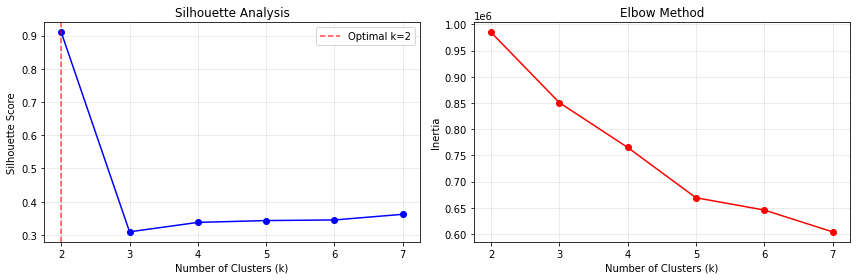

INFO:__main__:Average silhouette score: 0.910


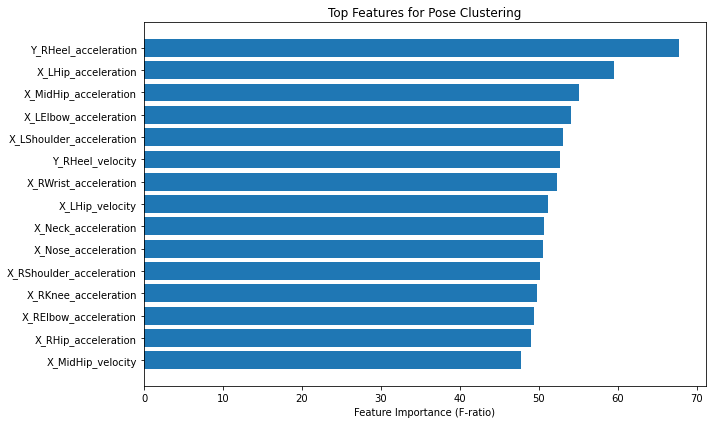

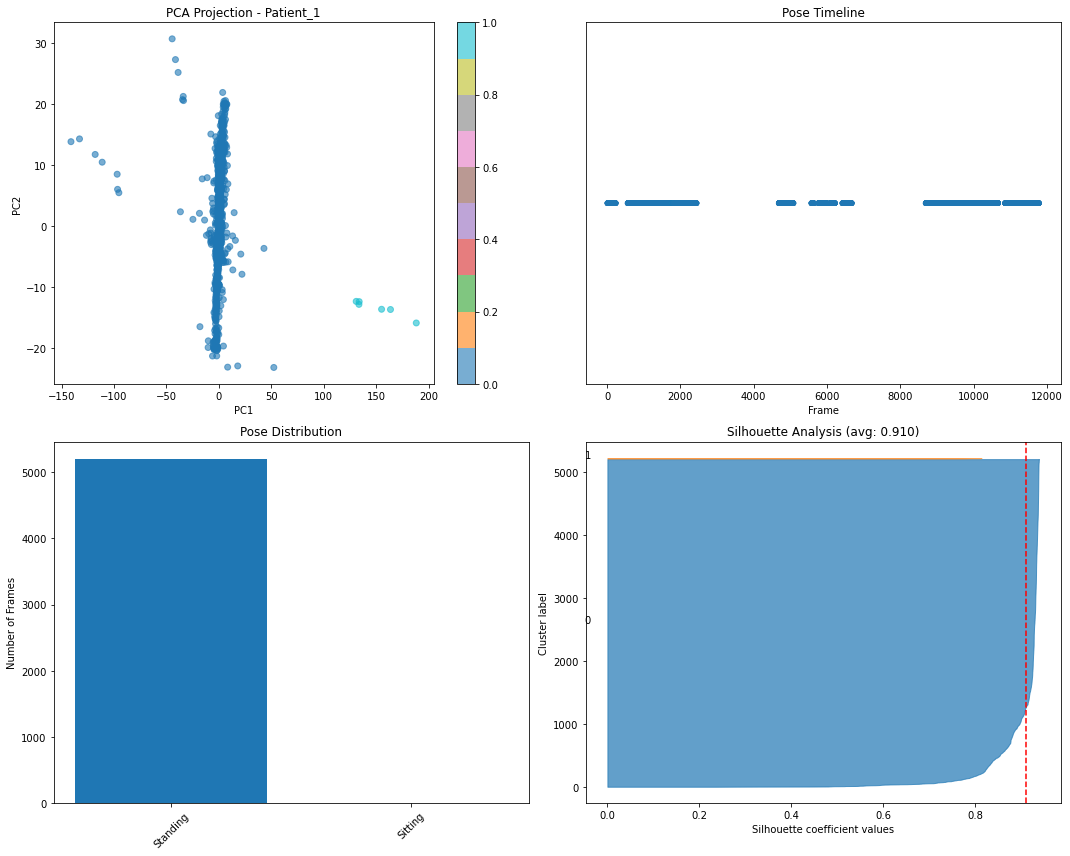

INFO:__main__:Pose distribution for Patient_1:
INFO:__main__:  Standing: 5201 frames (99.9%)
INFO:__main__:  Sitting: 6 frames (0.1%)
INFO:__main__:
=== Processing Therapist_1 ===
INFO:__main__:Extracting features for Therapist_1
INFO:__main__:Feature extraction complete. Shape: (3727, 216)
INFO:__main__:k=2: Silhouette=0.725, Inertia=603477.3
INFO:__main__:k=3: Silhouette=0.713, Inertia=508322.6
INFO:__main__:k=4: Silhouette=0.727, Inertia=436474.2
INFO:__main__:k=5: Silhouette=0.705, Inertia=395122.1
INFO:__main__:k=6: Silhouette=0.584, Inertia=365000.4
INFO:__main__:k=7: Silhouette=0.585, Inertia=341650.6
INFO:__main__:Optimal k based on silhouette score: 4


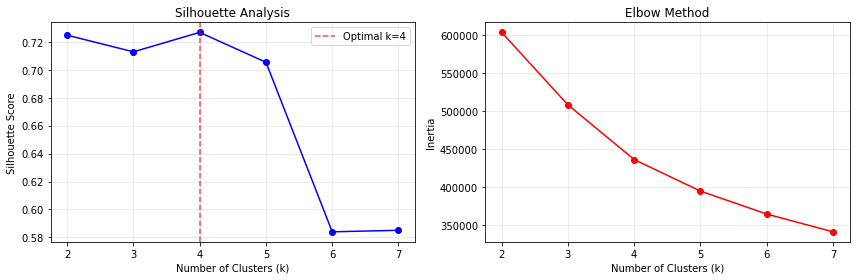

INFO:__main__:Average silhouette score: 0.727


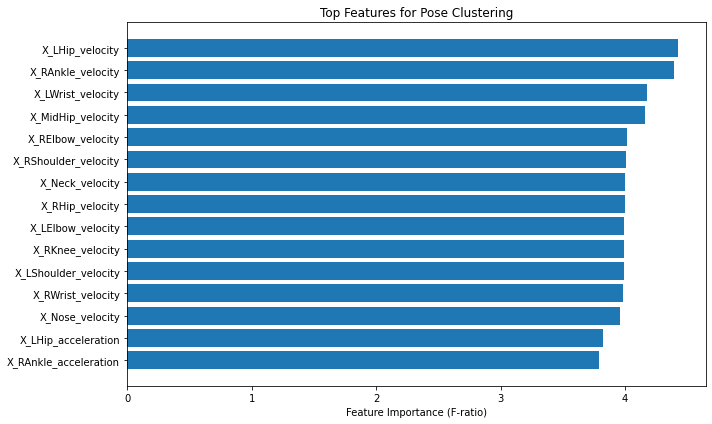

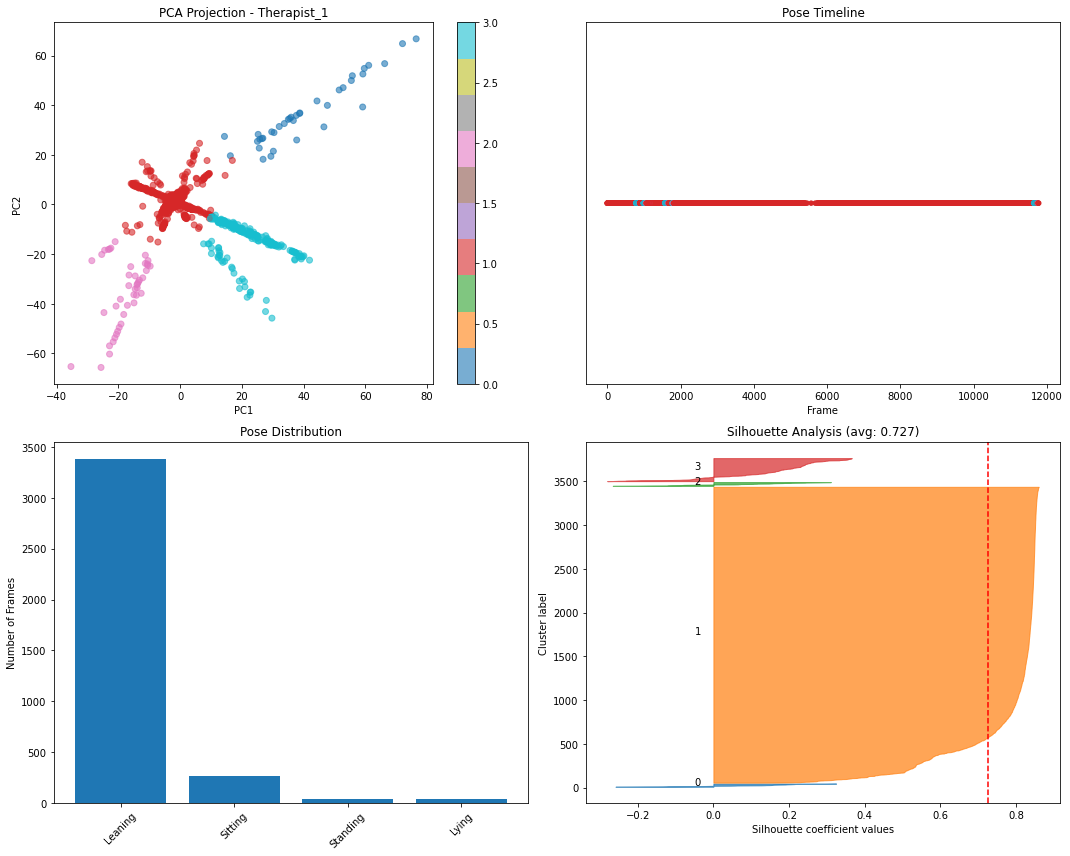

INFO:__main__:Pose distribution for Therapist_1:
INFO:__main__:  Leaning: 3382 frames (90.7%)
INFO:__main__:  Sitting: 264 frames (7.1%)
INFO:__main__:  Standing: 44 frames (1.2%)
INFO:__main__:  Lying: 37 frames (1.0%)
INFO:__main__:
=== Processing Therapist_2 ===
INFO:__main__:Extracting features for Therapist_2
INFO:__main__:Feature extraction complete. Shape: (4038, 216)
INFO:__main__:k=2: Silhouette=0.594, Inertia=679273.7
INFO:__main__:k=3: Silhouette=0.597, Inertia=620558.4
INFO:__main__:k=4: Silhouette=0.447, Inertia=562087.8
INFO:__main__:k=5: Silhouette=0.412, Inertia=507037.4
INFO:__main__:k=6: Silhouette=0.417, Inertia=479852.0
INFO:__main__:k=7: Silhouette=0.423, Inertia=440728.8
INFO:__main__:Optimal k based on silhouette score: 3


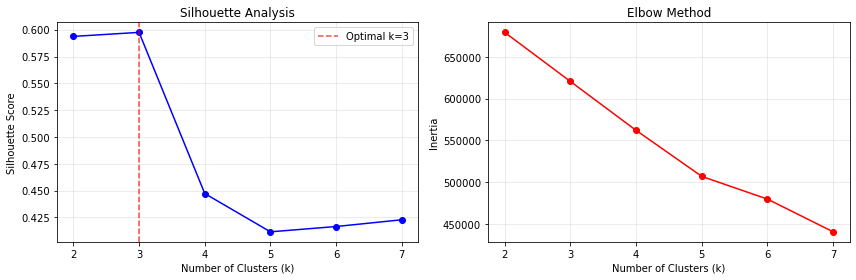

INFO:__main__:Average silhouette score: 0.597


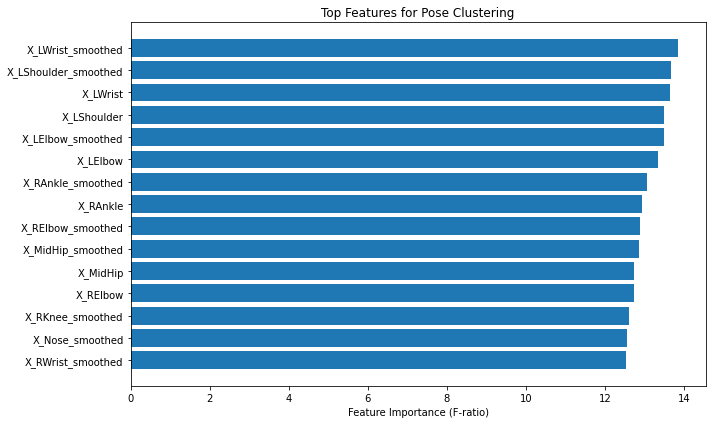

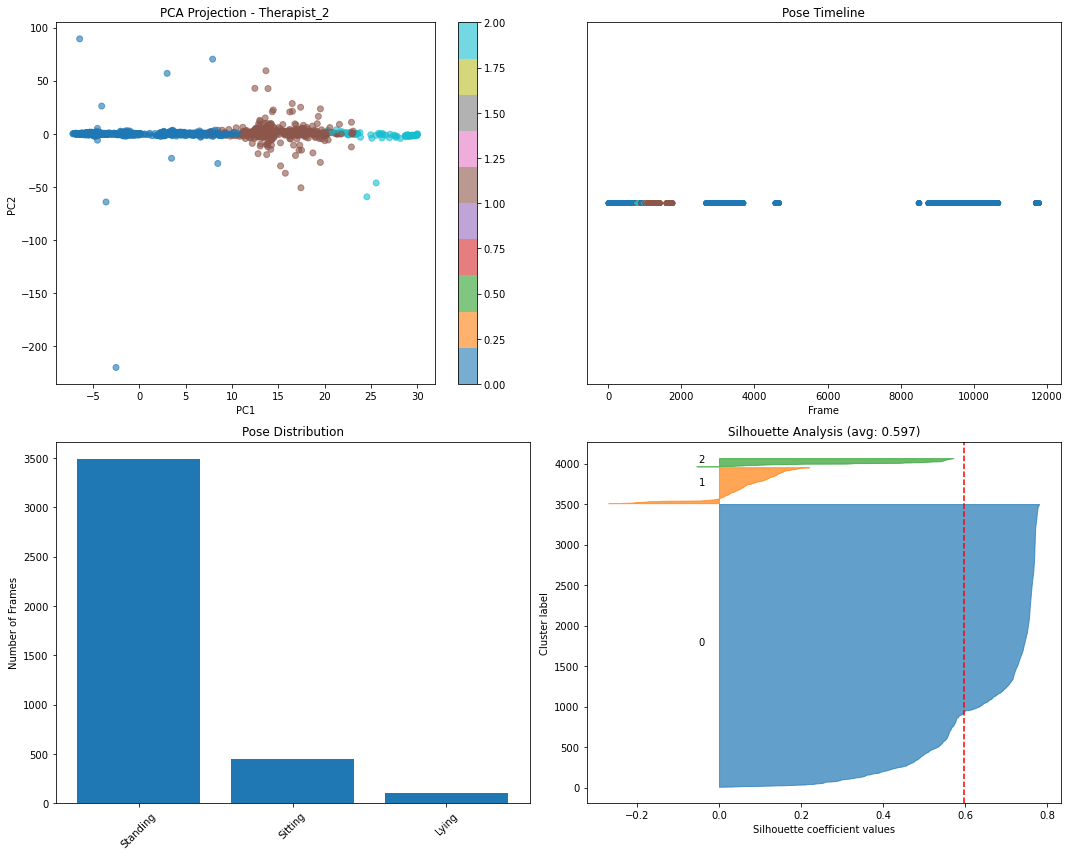

INFO:__main__:Pose distribution for Therapist_2:
INFO:__main__:  Standing: 3491 frames (86.5%)
INFO:__main__:  Sitting: 445 frames (11.0%)
INFO:__main__:  Lying: 102 frames (2.5%)


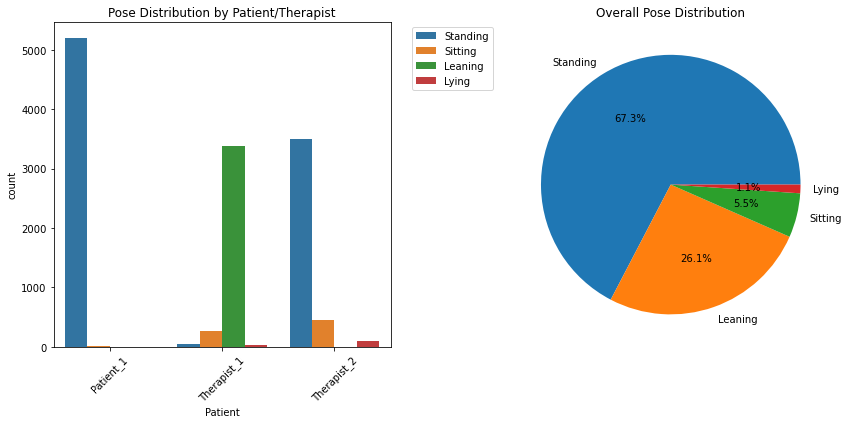

In [21]:
# 0. Load your data
# 1. Extract comprehensive features
# 2. Find optimal number of clusters
# 3. Analyze feature importance
# 4. Generate visualizations
# 5. Provide clinical interpretations

joint_positions = pd.read_csv("joint_positions.csv")
results = main_analysis(joint_positions)

In [29]:
results.to_csv("pose_classification.csv")

In [ ]:
start_trim_sec = 250    
end_trim_sec = 1300  

column_names = ["video","empty", "act_start_min",  "act_start_sec", "act_end_min", "act_end_sec", "duration_min", "duration_sec", "action"]
df_ma = pd.read_csv("/home/liubov/Bureau/feature_extraction/8-5-2024_#18_INDIVIDUAL_12.csv", sep='\t', names=column_names, header=None)
df_ma.drop(columns=["empty", "act_start_min", "act_end_min","duration_min"], inplace=True)
# df_ma.info()

df_ma.act_start_sec = df_ma.act_start_sec - start_trim_sec
df_ma.act_end_sec = df_ma.act_end_sec - start_trim_sec
df_ma = df_ma[df_ma.act_end_sec<end_trim_sec]
df_ma

subject_pose_mapping = {
    # Patient (Child)
    'CST': ('P', 'Standing'),
    'CHO': ('P', 'Leaning'),
    'CSI': ('P', 'Sitting'),
    'CGO': ('P', 'Other'),
    'CLF': ('P', 'Lying'),
    'CRE': ('P', 'Leaning'),
    'CCR': ('P', 'Leaning'),
    'AO': ('P', 'Other'),
    'AT': ('P', 'Other'),
    'GO': ('P', 'Other'),
    'GT': ('P', 'Other'),
    'CS': ('P', 'Other'),
    'CNS': ('P', 'Other'),
    'T_P': ('P', 'Other'),
    'T_V': ('P', 'Other'),
    'T1': ('P', 'Other'),
    'AT1': ('P', 'Other'),
    'AT4': ('P', 'Other'),
    'GT1': ('P', 'Other'),
    'GT4': ('P', 'Other'),

    # Therapist
    'TST': ('T', 'Standing'),
    'THO': ('T', 'Leaning'),
    'TSI': ('T', 'Sitting'),
    'TGO': ('T', 'Other'),
    'TLF': ('T', 'Lying'),
    'TRE': ('T', 'Leaning'),
    'TCR': ('T', 'Leaning'),
    'TS': ('T', 'Other'),
    'TNS': ('T', 'Other'),
    'C': ('T', 'Other'),

    # Both
    'TC': ('Both', 'Other'),
    'PL': ('Both', 'Other'),
    'T': ('Both', 'Other'),
    'JA': ('Both', 'Other'),

    # Unknown
    '': ('Unknown', 'Other')
}


### Comparison with Manually-anotated

In [25]:
# Create new columns from the mapping dict, assigning NaN for unknowns
df_ma[['subject', 'pose_category']] = df_ma['action'].map(subject_pose_mapping).apply(
    lambda x: pd.Series(x) if isinstance(x, tuple) else pd.Series(('Unknown', 'Other'))
)

In [26]:
df_ma

,video,act_start_sec,act_end_sec,duration_sec,action,subject,pose_category
0,c12_CP,1.336,93.688,92.352,CHO,P,Leaning
1,c12_CP,94.086,99.592,5.506,CST,P,Standing
2,c12_CP,99.869,132.516,32.647,CSI,P,Sitting
3,c12_CP,133.067,294.257,161.190,CST,P,Standing
4,c12_CP,294.257,296.673,2.416,CHO,P,Leaning
...,...,...,...,...,...,...,...
783,c12_CG,944.743,945.929,1.186,GT1,P,Other
784,c12_CG,949.539,952.521,2.982,GT1,P,Other
785,c12_CG,954.576,971.484,16.908,GO,P,Other
786,c12_CG,971.484,972.095,0.611,GT4,P,Other


In [27]:
df_ma[df_ma['pose_category']!='Other']

,video,act_start_sec,act_end_sec,duration_sec,action,subject,pose_category
0,c12_CP,1.336,93.688,92.352,CHO,P,Leaning
1,c12_CP,94.086,99.592,5.506,CST,P,Standing
2,c12_CP,99.869,132.516,32.647,CSI,P,Sitting
3,c12_CP,133.067,294.257,161.190,CST,P,Standing
4,c12_CP,294.257,296.673,2.416,CHO,P,Leaning
5,c12_CP,296.674,315.607,18.933,CST,P,Standing
6,c12_CP,316.012,795.597,479.585,CSI,P,Sitting
7,c12_CP,796.233,877.688,81.455,CST,P,Standing
8,c12_CP,877.688,903.688,26.000,CHO,P,Leaning
9,c12_CP,903.688,982.488,78.800,CST,P,Standing
